In [73]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns

In [66]:
etfs = [
    'SPY', 'VGK', 'IEF', 'LQD', 'USO', 'GLD', 'VNQ', 'RWO', 'IWM', 'HYG', 'DBC'
]

adj_close = pd.read_csv('historical_prices.csv', index_col='Date', parse_dates=True)

returns = adj_close.pct_change().dropna()

In [67]:
returns

,DBC,GLD,HYG,IEF,IWM,LQD,RWO,SPY,USO,VGK,VNQ
Date,,,,,,,,,,,
2010-01-05,0.001189,-0.000911,0.004745,0.004391,-0.003438,0.004776,0.004011,0.002647,0.003477,-0.001601,-0.001123
2010-01-06,0.017808,0.016500,0.002585,-0.004036,-0.000941,-0.002947,-0.006146,0.000704,0.013858,0.006014,-0.001798
2010-01-07,-0.012442,-0.006188,0.004037,0.000000,0.007379,0.001239,0.004639,0.004221,-0.006102,-0.006377,0.010806
2010-01-08,-0.000787,0.004963,0.001563,0.001238,0.005454,0.002190,-0.001540,0.003328,0.005157,0.010028,-0.007350
2010-01-11,-0.003152,0.013289,-0.000892,0.000675,-0.004030,0.001045,0.005857,0.001397,-0.009528,0.007943,0.005834
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,0.018272,0.002998,0.002560,-0.004527,0.004551,-0.003073,0.004429,0.005752,0.023929,0.003246,0.008901
2022-12-27,0.008972,0.008430,-0.010351,-0.008372,-0.006709,-0.012890,0.000245,-0.003943,0.003029,0.001977,-0.000363
2022-12-28,-0.011318,-0.004506,-0.013447,-0.002397,-0.015529,-0.003123,-0.013715,-0.012428,-0.013663,-0.009150,-0.017047


In [68]:
def portfolio_variance(weights, cov_matrix):
    return weights.T @ cov_matrix @ weights

In [69]:
def risk_contribution(weights, cov_matrix):
    portfolio_var = portfolio_variance(weights, cov_matrix)
    marginal_contrib = cov_matrix @ weights
    risk_contrib = np.multiply(marginal_contrib, weights) / portfolio_var
    return risk_contrib

In [70]:
def objective_function(weights, cov_matrix):
    risk_contrib = risk_contribution(weights, cov_matrix)
    target_risk = np.mean(risk_contrib)
    return np.sum((risk_contrib - target_risk) ** 2)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.3847717977700715e-08
            Iterations: 24
            Function evaluations: 306
            Gradient evaluations: 24
Risk Parity Weights:
      Weights
SPY  0.058986
VGK  0.083904
IEF  0.095410
LQD  0.377513
USO  0.040639
GLD  0.133792
VNQ  0.043226
RWO  0.050869
IWM  0.033170
HYG  0.041859
DBC  0.040631


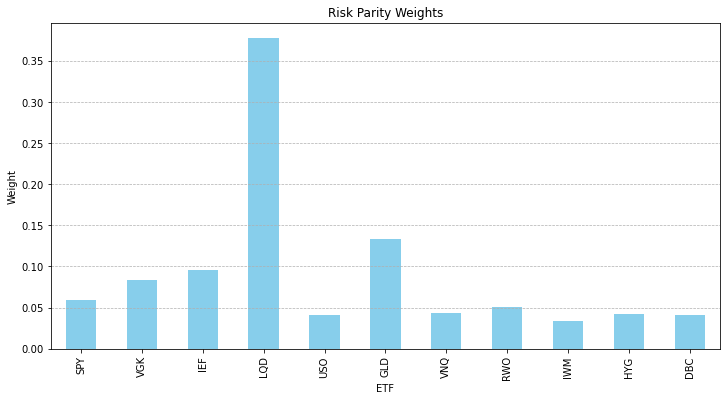

In [71]:
constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}

bounds = [(0, 1) for _ in range(len(etfs))]

initial_guess = np.ones(len(etfs)) / len(etfs)

cov_matrix = returns.cov().values

options = {
    'disp': True,   
    'maxiter': 1000,     
}

result = minimize(objective_function, initial_guess, args=(cov_matrix,), constraints=constraints, tol=1e-6, bounds=bounds, options=options)

risk_parity_weights = result.x

risk_parity_weights_df = pd.DataFrame(risk_parity_weights, index=etfs, columns=['Weights'])

print("Risk Parity Weights:")
print(risk_parity_weights_df)

risk_parity_weights_df.plot(kind='bar', legend=False, figsize=(12, 6), color='skyblue')
plt.title('Risk Parity Weights')
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.ylabel('Weight')
plt.xlabel('ETF')
plt.show()

In [72]:
import numpy as np

mean_returns = returns.mean()

expected_portfolio_return = np.sum(risk_parity_weights * mean_returns)

portfolio_variance = portfolio_variance(risk_parity_weights, returns.cov().values)

portfolio_risk = np.sqrt(portfolio_variance)

annualized_return = (1 + expected_portfolio_return) ** 252 - 1
annualized_return_percent = annualized_return * 100
print(f"Annualized Expected Portfolio Return: {annualized_return_percent:.2f}%")

annualized_volatility = portfolio_risk * np.sqrt(252)
annualized_volatility_percent = annualized_volatility * 100
print(f"Annualized Portfolio Risk (Volatility): {annualized_volatility_percent:.2f}%")

Annualized Expected Portfolio Return: 4.57%
Annualized Portfolio Risk (Volatility): 6.87%


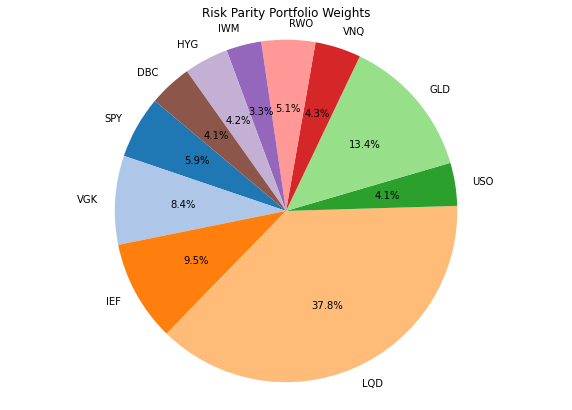

In [34]:
plt.figure(figsize=(10, 7), facecolor='white')
plt.pie(risk_parity_weights, labels=etfs, autopct='%1.1f%%', startangle=140, colors=plt.cm.tab20.colors)
plt.title('Risk Parity Portfolio Weights')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

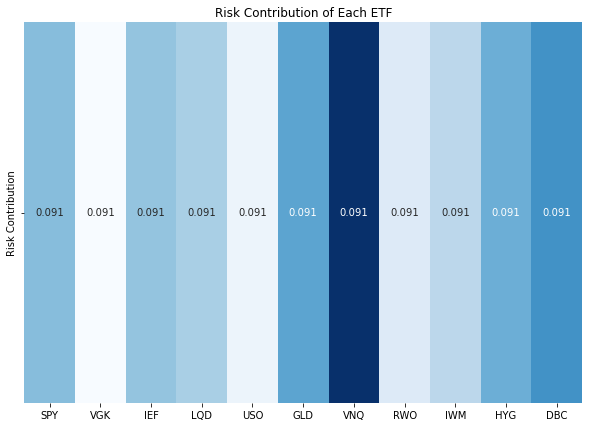

In [49]:
optimal_risk_contrib = risk_contribution(risk_parity_weights, cov_matrix)

risk_contrib_df = pd.DataFrame(optimal_risk_contrib, index=etfs, columns=['Risk Contribution'])

# Plot heatmap of risk contributions
plt.figure(figsize=(10, 7), facecolor='white')
sns.heatmap(risk_contrib_df.T, annot=True, cmap='Blues', cbar=False)
plt.title('Risk Contribution of Each ETF')
plt.show()

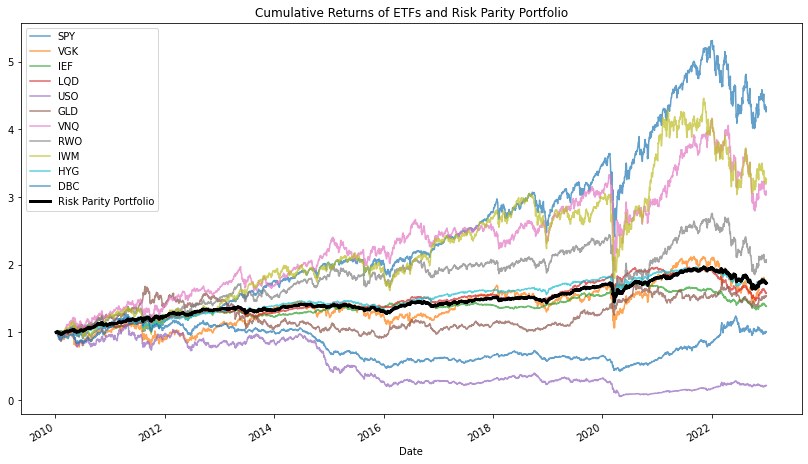

In [43]:
cumulative_returns = (1 + returns).cumprod()

portfolio_returns = returns.dot(risk_parity_weights)
cumulative_portfolio_returns = (1 + portfolio_returns).cumprod()

plt.figure(figsize=(14, 8), facecolor='white')
for etf in etfs:
    cumulative_returns[etf].plot(label=etf, alpha=0.7)
cumulative_portfolio_returns.plot(label='Risk Parity Portfolio', linewidth=3, color='black')
plt.title('Cumulative Returns of ETFs and Risk Parity Portfolio')
plt.legend()
plt.show()

In [62]:
cumulative_portfolio_returns

Date
2010-01-05    1.002914
2010-01-06    1.004051
2010-01-07    1.004034
2010-01-08    1.005937
2010-01-11    1.007600
                ...   
2022-12-23    1.742037
2022-12-27    1.733448
2022-12-28    1.721251
2022-12-29    1.736478
2022-12-30    1.733112
Length: 3271, dtype: float64